#Bird Species Classification#

By: Saul Moran, Sierra Svetlik, Grace Okamoto



**Importing the dataset**

https://www.kaggle.com/datasets/gpiosenka/100-bird-species

In [ ]:
#installing Kaggle API in Colab
!pip install kaggle

Importing and uploading the 'kaggle.json' file to get the data from Kaggle.

In [ ]:
# for this portion of the code you must upload the 'kaggle.json' from the drive folder.
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
# download bird species data to environment
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [00:25<00:00, 65.8MB/s]
100% 1.96G/1.96G [00:25<00:00, 83.7MB/s]


In [ ]:
# unzip data folders
!unzip 100-bird-species

Streaming output truncated to the last 5000 lines.
  inflating: train/WHITE TAILED TROPIC/120.jpg  
  inflating: train/WHITE TAILED TROPIC/121.jpg  
  inflating: train/WHITE TAILED TROPIC/122.jpg  
  inflating: train/WHITE TAILED TROPIC/123.jpg  
  inflating: train/WHITE TAILED TROPIC/124.jpg  
  inflating: train/WHITE TAILED TROPIC/125.jpg  
  inflating: train/WHITE TAILED TROPIC/126.jpg  
  inflating: train/WHITE TAILED TROPIC/127.jpg  
  inflating: train/WHITE TAILED TROPIC/128.jpg  
  inflating: train/WHITE TAILED TROPIC/129.jpg  
  inflating: train/WHITE TAILED TROPIC/130.jpg  
  inflating: train/WHITE TAILED TROPIC/131.jpg  
  inflating: train/WHITE TAILED TROPIC/132.jpg  
  inflating: train/WHITE TAILED TROPIC/133.jpg  
  inflating: train/WHITE TAILED TROPIC/134.jpg  
  inflating: train/WHITE TAILED TROPIC/135.jpg  
  inflating: train/WHITE TAILED TROPIC/136.jpg  
  inflating: train/WHITE TAILED TROPIC/137.jpg  
  inflating: train/WHITE TAILED TROPIC/138.jpg  
  inflating: train

#SVM model implementation#

SVC(), default parameters on random classes (2 <= n <= 12)

In [ ]:
import pandas as pd
import gc
import numpy
import random
from sklearn import svm
from google.colab import files
from sklearn.model_selection import train_test_split
from skimage.io import imread
pd.options.mode.chained_assignment = None
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
#Need to disable this warning, otherwise it will come up thousands of
#times when birds_subset is being occupied

#Much of the code has been borrowed and adapted from
#https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01



num_species = [2,3,4,5,6,7,8,9,10,11,12]
accuracy = []

for n in num_species:
  basepath = "birds.csv"
  birds_df = pd.read_csv(basepath)
  #birds_df.head()
  labels = birds_df["labels"]
  label_subset = []
  birds_subset = []
  img_array = []
  #Since birds.csv contains 89885 datapoints (525 species), we reduce it down to
  #a smaller number of species
  #The reason is that it will otherwise run out of RAM
  rand = random.seed()
  uniq_labels = labels.unique()
  while (len(label_subset) < n): # changed to ten species, continues to crash -Saul
  #Lets keep it to 10 or less for now, but 10 works for me -Sierra
    i = random.randint(0, len(uniq_labels) - 1)
    label_subset.append(uniq_labels[i])
    numpy.delete(uniq_labels, i)

  #A fraction of the original species/labels are chosen at random
  #For each of the randomly chosen labels, find the respective datapoints and add
  #them to a new subset
  for i in label_subset:
    if (len(birds_subset) == 0):
      birds_subset = birds_df[labels == i]
    else:
      new_rows = birds_df[labels == i]
      for j in range(len(new_rows)):
        birds_subset.loc[len(birds_subset.index)] = new_rows.iloc[j]

  #In order to help save on RAM, delete now unnecessary variables
  del birds_df
  del uniq_labels
  del label_subset
  gc.collect()

  #All we need is the filepaths and labels from this point on
  birds = birds_subset["filepaths"]
  labels = birds_subset["labels"]

  print("Birds:", len(birds), "Labels", len(labels))

  #Locate and shape the images in preparation for the model
  #Use try and except to keep it from crashing if something goes wrong
  for i in birds:
    i.replace("  ", " ")
    try:
    #photo = imread("/content/data/" + i)
      #photo is an ndarray of shape 224*224*3, containing imformation about the
      #photos RGB make-up
      photo = imread(i)
      #It is flattened into the 1D array of shape 150528,
      img_array.append(photo.flatten())
    except:
      #It won't always be a bad path, but it is most of the time
      #If it's not a bad path, and the source of the bug is elusive
      #Comment out the try and except and see where it crashes
      string = "content/data/" + i + " does not exist"
      print(string)

  #More garbage collection
  del birds
  gc.collect()

  #Final preparation of the data for training and testing
  df = pd.DataFrame(numpy.array(img_array))
  df['Labels'] = numpy.array(labels)
  X = df.iloc[:, :-1]
  Y = df.iloc[:,-1]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

  #More garbage collection
  del df
  del img_array
  del photo
  gc.collect()

  # make a pipeline
  model = make_pipeline(StandardScaler(), svm.SVC())

  #Fit the model
  print(type(X_train), X_train.shape)
  model.fit(X_train, Y_train)
  model.score(X_test, Y_test)

  #Model Testing
  Y_pred = model.predict(X_test)


  # Model Evaluation
  from sklearn import metrics
  accuracy.append(metrics.accuracy_score(Y_pred, Y_test))
  print(f"The model training {n} species has accuracy {metrics.accuracy_score(Y_pred, Y_test) * 100}% accurate.")
  print(classification_report(Y_test, Y_pred))

Birds: 341 Labels 341
<class 'pandas.core.frame.DataFrame'> (272, 150528)
The model training 2 species has accuracy 75.36231884057972% accurate.
                  precision    recall  f1-score   support

CHUKAR PARTRIDGE       0.70      0.77      0.73        30
       TIT MOUSE       0.81      0.74      0.77        39

        accuracy                           0.75        69
       macro avg       0.75      0.76      0.75        69
    weighted avg       0.76      0.75      0.75        69

Birds: 493 Labels 493
<class 'pandas.core.frame.DataFrame'> (394, 150528)
The model training 3 species has accuracy 84.84848484848484% accurate.
                        precision    recall  f1-score   support

    ANTILLEAN EUPHONIA       0.83      0.80      0.81        30
BLACK-THROATED SPARROW       0.92      0.95      0.93        37
     RUFOUS KINGFISHER       0.78      0.78      0.78        32

              accuracy                           0.85        99
             macro avg       0.84    

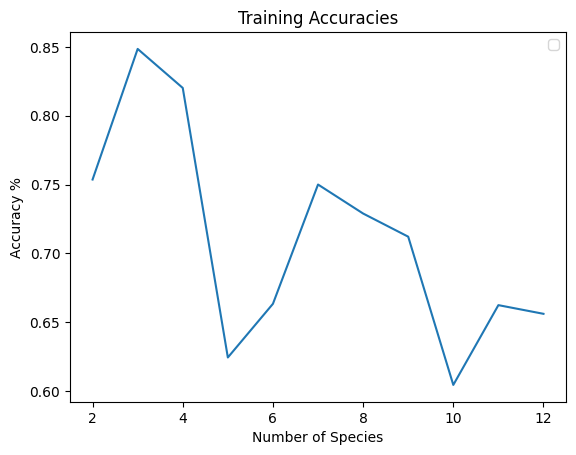

In [ ]:
# plot accuracy vs number of classes
from matplotlib import pyplot as plt

num_species = [2,3,4,5,6,7,8,9,10,11,12]
if len(accuracy) == 0:
  accuracy = [81.0,79.5,71.4,71.8,52.6, 71.5, 69.0, 67.8,58.4,54.3] # got these from previous run.
plt.plot(num_species, accuracy)
plt.title("Accuracies vs Number of Species")
plt.xlabel("Number of Species")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()